In [1]:
# Miscellaneous operating system interfaces
import os

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from datetime import datetime

import xskillscore as xs
import scipy

import cftime

import climpred
from climpred import HindcastEnsemble

/home/dmercado/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dmercado/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
variable="t2m" #temperature

# ERA5

In [3]:
# Load ERA5 observed data
#datadir = 'homedir'
#os.chdir(datadir)
lat = 2
lon = (-140)

In [4]:
#load era5 data
era5_obs = xr.open_dataset("data/era5_jma.nc")
#era5_obs["t2m"].plot()

In [5]:
#mean values for all coordinates
era5_obs = era5_obs.sel(latitude=lat, longitude=lon, method="nearest")
verifds = era5_obs.rename({"valid_time": "time"})
verifds = verifds.drop_vars(["number", "expver"])

In [6]:
verifds

<xarray.Dataset> Size: 12kB
Dimensions:    (time: 1020)
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-12-01
    latitude   float64 8B 2.0
    longitude  float64 8B -140.0
Data variables:
    t2m        (time) float32 4kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

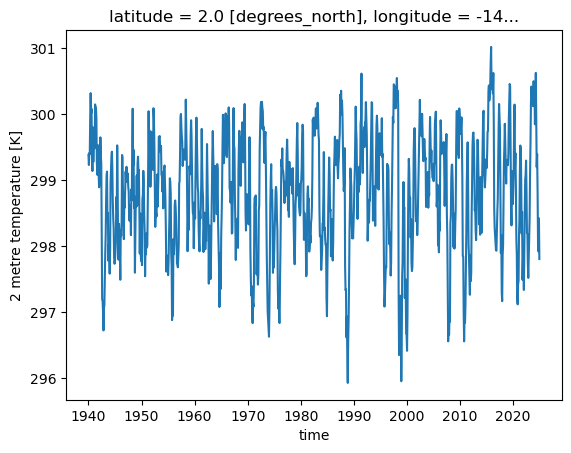

In [7]:
verifds["t2m"].plot()

# SEAS5

In [8]:
#load era5 data
seas5 = xr.open_dataset("data/seas5_jma.nc")
#seas5["t2m"].plot()

In [9]:
#mean values for all coordinates
seas5 = seas5.sel(latitude=lat, longitude=lon, method="nearest")

In [10]:
fcstds = seas5.rename({'forecast_reference_time': 'init', 'forecastMonth': 'lead', 'number': 'member'})

In [11]:
fcstds

<xarray.Dataset> Size: 263kB
Dimensions:    (member: 25, init: 432, lead: 6)
Coordinates:
  * member     (member) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * init       (init) datetime64[ns] 3kB 1981-01-01 1981-02-01 ... 2016-12-01
  * lead       (lead) int64 48B 1 2 3 4 5 6
    latitude   float64 8B 2.0
    longitude  float64 8B -140.0
Data variables:
    t2m        (member, init, lead) float32 259kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-27T08:34 GRIB to CDM+CF via cfgrib-0.9.1...

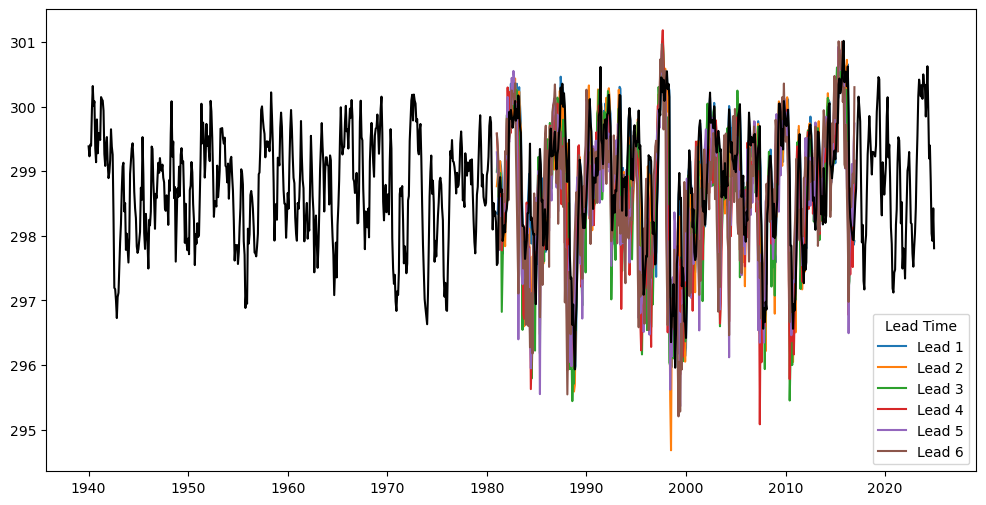

In [12]:
t2m_member = fcstds.sel(member=1)
plt.figure(figsize=(12, 6))

for lead in t2m_member["lead"].values:  # Iterate through lead times
    plt.plot(
        t2m_member["init"].values, 
        t2m_member.sel(lead=lead)["t2m"], 
        label=f"Lead {lead}"
    )
plt.plot(verifds["time"].values, verifds["t2m"], "black")
plt.legend(title="Lead Time")

# Start verification

In [13]:
#select specific date for era5 and seas5
fcstds = fcstds.sel(init=slice("1993-01-01", "2016-12-01"))
verifds = verifds.sel(time=slice("1993-01-01", "2016-12-01"))

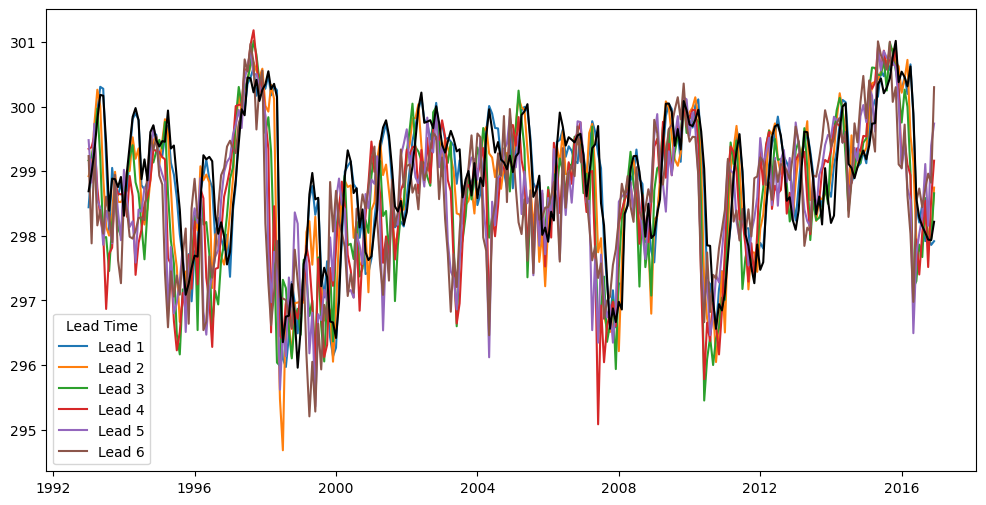

In [14]:
t2m_member = fcstds.sel(member=1)
plt.figure(figsize=(12, 6))

for lead in t2m_member["lead"].values:  # Iterate through lead times
    plt.plot(
        t2m_member["init"].values, 
        t2m_member.sel(lead=lead)["t2m"], 
        label=f"Lead {lead}"
    )
plt.plot(verifds["time"].values, verifds["t2m"], "black")
plt.legend(title="Lead Time")

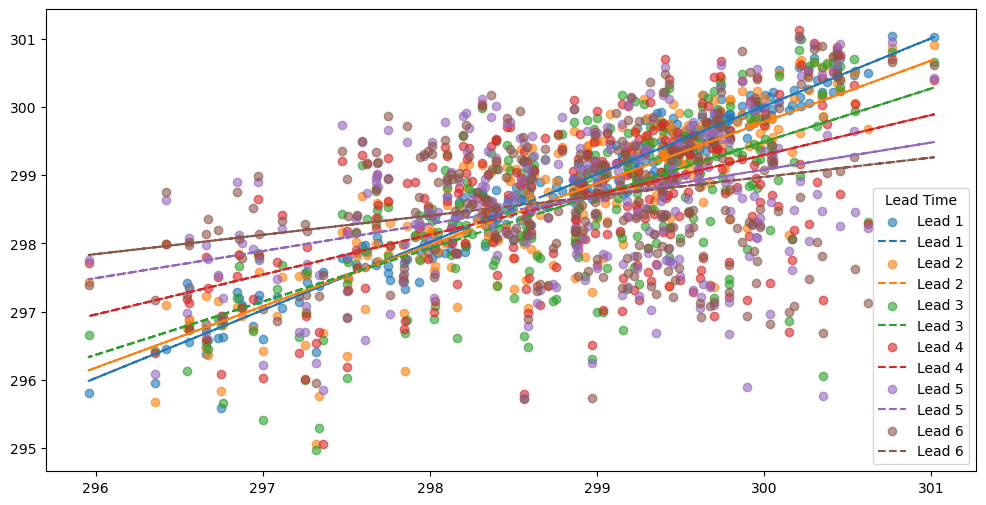

In [15]:
t2m_member = fcstds.sel(member=24)
plt.figure(figsize=(12, 6))

for lead in t2m_member["lead"].values:  # Iterate through lead times
    x = verifds["t2m"].values  # Observations
    y = t2m_member.sel(lead=lead)["t2m"].values  # Forecasts for each lead
    
    # Scatter plot
    plt.scatter(x, y, label=f"Lead {lead}", alpha=0.6)
    
    # Regression line
    coeffs = np.polyfit(x, y, 1)  # Linear fit (degree=1)
    reg_line = np.polyval(coeffs, x)
    plt.plot(x, reg_line, linestyle="--", label=f"Lead {lead}")
    
plt.legend(title="Lead Time")

In [16]:
#add months as units in the lead months to avoid error in HindcastEnsemble
fcstds["lead"].attrs["units"] = "months"
#create ensemble for seas5 and add era5
hindcast = climpred.HindcastEnsemble(fcstds).add_observations(verifds)

In [17]:
hindcast = hindcast.remove_bias(alignment="same_verifs")

/home/dmercado/.local/lib/python3.10/site-packages/climpred/classes.py:2370: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


In [18]:
hindcast = hindcast.remove_seasonality("month")  # remove seasonal cycle

/home/dmercado/.local/lib/python3.10/site-packages/climpred/classes.py:684: UserWarning: Error due to initialized:  _remove_seasonality({'seasonality': 'month'}) failed
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
  warnings.warn(f"Error due to initialized:  {msg}")
/home/dmercado/.local/lib/python3.10/site-packages/climpred/classes.py:690: UserWarning: Error due to verification/control/uninitialized: _remove_seasonality({'seasonality': 'month'}) failed
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
  warnings.warn(


In [19]:
#hindcast = hindcast.drop_vars("valid_time")

### Skill for each specific initialisation

In [20]:
result_crpss = []
alignment = "same_inits"#"maximize"#"same_inits"
for month in range(1,13):
    fcstds_month = fcstds.sel(init=fcstds["init"].dt.month == month)
    hindcast_month = HindcastEnsemble(fcstds_month).add_observations(verifds)
    skill = hindcast_month.verify(
        metric="crpss", comparison="m2o", alignment=alignment, dim=["init", "member"]
    )
    result_crpss.append(skill)
result_crpss = xr.concat(result_crpss, dim='month')
result_crpss['month'] = np.arange(12) + 1

## Option 1: Plot heatmap with all CRPSS values for each month and lead time

Text(0, 0.5, 'Lead Time (Months)')

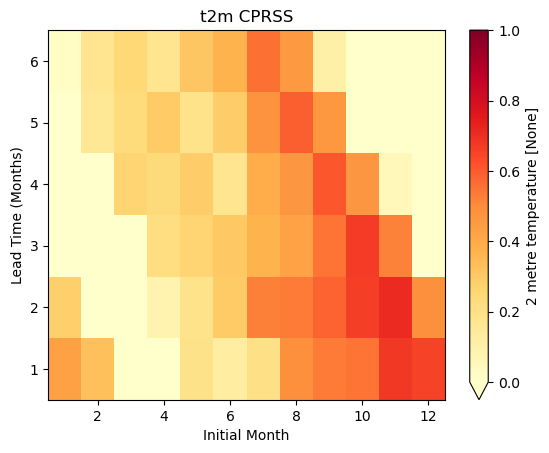

In [21]:
result_crpss["t2m"].plot(y='lead', cmap='YlOrRd',
               vmin=0.0,
               vmax=1.0)

plt.title(variable + ' CPRSS')
plt.xlabel('Initial Month')
plt.ylabel('Lead Time (Months)')

## Option 2: Plot heatmap with all CRPSS values for each month and lead time

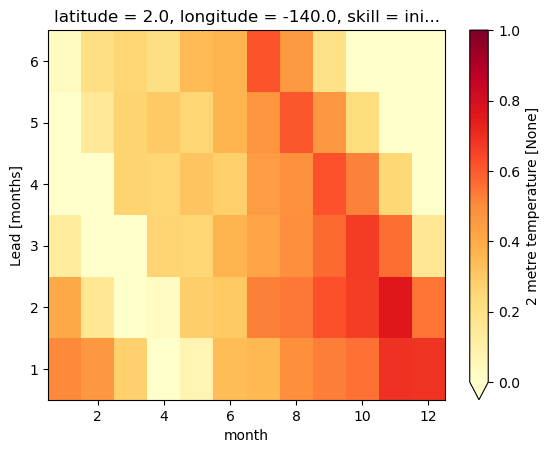

In [25]:
alignment = "same_inits"#"same_inits"#"maximize"#"same_inits"
skill = hindcast.verify(metric='crpss', comparison='m2o', dim=['init','member'], alignment=alignment, groupby='month')
skill.t2m.plot(y="lead", cmap="YlOrRd", vmin=0.0, vmax=1.0)

## Plot heatmap with all Anomaly Correlation Coefficient 

In [26]:
alignment = "same_inits"#"same_inits"#"maximize"#"same_inits"
skill = hindcast.verify(metric='acc', comparison='m2o', dim=['init','member'], alignment=alignment, groupby='month')

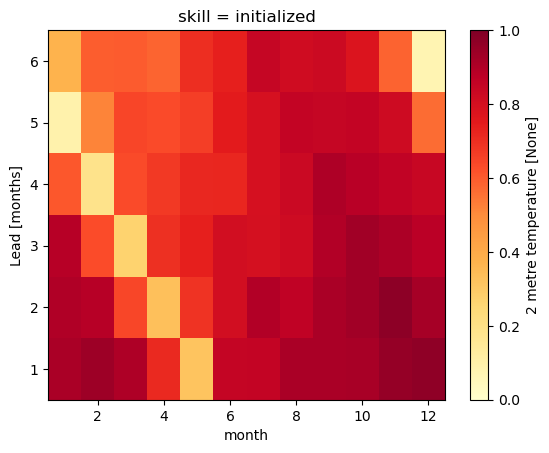

In [27]:
skill.t2m.plot(y="lead", cmap="YlOrRd", vmin=0.0, vmax=1.0)